# RNN for trasnfer function prediction by Seq2Seq model

In [82]:
import torch 
import pandas as pd 
import pickle
import numpy as np
import os
import sys 

from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from tqdm import trange

sns.set_theme()

In [83]:
path = r'FLAC\FLAC2D\1D 1 Column\Results2'

In [84]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_1000.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_1000.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

# Get Vs_data less than 800
index = Vs_data <= 800
TTF_data = TTF_data[index]
Vs_data = Vs_data[index]

print(TTF_data.shape, Vs_data.shape,freq_data.shape)


(750, 1000) (750,) (1000,)


Text(0.5, 1.0, 'Vs = 108.96 m/s')

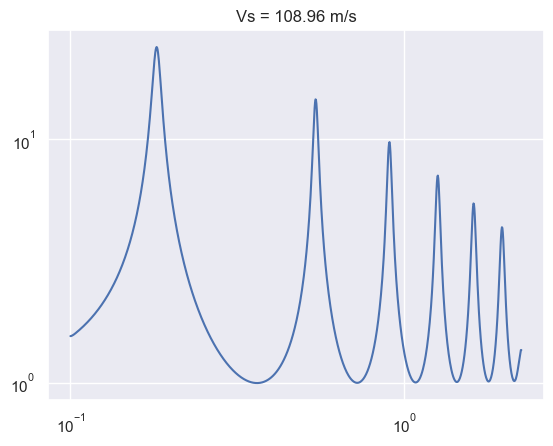

In [85]:
normalized_TTF_data = False

if normalized_TTF_data:
    TTF_values = normalization(TTF_data)
else:
    TTF_values = TTF_data

plt.loglog(freq_data, TTF_values[9,:], label="TTF")
plt.title(f"Vs = {Vs_data[9]:.2f} m/s")

In [86]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):

        input_data = self.Vs_values[idx] * np.ones(30)
        input_data = torch.tensor(input_data, dtype=torch.float32).unsqueeze(1)

        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32)
        return input_data, target_data

In [87]:
dataset = TTF_dataset(TTF_values, Vs_data)
print("Sizes in the dataset: ", len(dataset))
print("Data shapes for input and target: ", dataset[0][0].shape, dataset[0][1].shape)

# Separate into training and testing
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " ,train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))

Sizes in the dataset:  750
Data shapes for input and target:  torch.Size([30, 1]) torch.Size([1000])
Train, validation and test sizes:  600 75 75
Number of batches:  12 2 2


# Model

## MLP

In [88]:
# Create Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU, batch_norm=False):
        super(MLP, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.batch_norm = batch_norm
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        if self.batch_norm:
            self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            if self.batch_norm:
                self.hidden_layers.append(nn.BatchNorm1d(hidden_dim))

        # Output layer
        self.out = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                x = layer(x)
                x = self.activation()(x)
            elif isinstance(layer, nn.BatchNorm1d):
                x = layer(x)
        x = self.out(x)
        return x

## CNN1D

In [89]:
class CNN_1D(nn.Module):
    def __init__(self, input_size, kernel_size, hidden_dim, hidden_layers, output_dim=1, activation=nn.ReLU):
        super(CNN_1D, self).__init__()
        self.hidden_layers = nn.ModuleList()
        self.activation = activation
        self.output_dim = output_dim

        # Input layer
        self.hidden_layers.append(nn.Conv1d(input_size, hidden_dim, kernel_size))
        self.hidden_layers.append(nn.MaxPool1d(2))

        # Additional hidden layers
        for _ in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Conv1d(hidden_dim, hidden_dim, kernel_size))
            self.hidden_layers.append(nn.MaxPool1d(2))

        # Adaptive pooling layer to reduce sequence length to 1
        self.hidden_layers.append(nn.AdaptiveAvgPool1d(1))

    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation()(x)
        return x

## Attention layer

In [90]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        self.hidden_size = hidden_size
        self.attention = nn.Linear(hidden_size, hidden_size)
        self.softmax = nn.Softmax(dim=1)
        self.context_vector = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, lstm_outputs):
        # Compute attention scores
        attention_scores = self.context_vector(torch.tanh(self.attention(lstm_outputs)))
        attention_weights = self.softmax(attention_scores)
        
        # Compute context vector
        context_vector = torch.sum(attention_weights * lstm_outputs, dim=1)
        
        return context_vector, attention_weights


## LSTM

In [91]:
class EncoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(EncoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AttentionLayer(hidden_size * (2 if bidirectional else 1))

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_outputs, _ = self.lstm(x, (h0, c0))
        
        # Apply attention mechanism
        context_vector, attention_weights = self.attention(lstm_outputs)
        
        return context_vector, attention_weights

class DecoderLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_features, output_size, bidirectional=False):
        super(DecoderLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_features)
        self.output_fc = nn.Linear(output_features * 30, output_size)
    
    def forward(self, x, context_vector):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_outputs, _ = self.lstm(x, (h0, c0))
        
        # Apply attention mechanism
        lstm_outputs = lstm_outputs + context_vector.unsqueeze(1)
        
        # Decode the hidden state of the last time step
        out = self.fc(lstm_outputs)

        # Reshape and map to desired output size
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.output_fc(out)  # Map to desired output size
        return out

In [92]:
model = EncoderLSTM(input_size=1, hidden_size=64, num_layers=1, bidirectional=True)
y = model(torch.rand(50, 30, 1))
print(y[0].shape, y[1].shape)
decoder = DecoderLSTM(input_size=1, hidden_size=64, num_layers=1, output_features=10, output_size=1000, bidirectional=True)
y2 = decoder(y[1], y[0])
print(y2.shape)

torch.Size([50, 128]) torch.Size([50, 30, 1])
torch.Size([50, 1000])


## GRU

In [93]:
class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(EncoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.attention = AttentionLayer(hidden_size * (2 if bidirectional else 1))

    def forward(self, x):
        # Set initial hidden state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        gru_outputs, _ = self.gru(x, h0)
        
        # Apply attention mechanism
        context_vector, attention_weights = self.attention(gru_outputs)
        
        return context_vector, attention_weights

class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_features, output_size, bidirectional=False):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_size * (2 if bidirectional else 1), output_features)
        self.output_fc = nn.Linear(output_features * 30, output_size)
    
    def forward(self, x, context_vector):
        # Set initial hidden state
        h0 = torch.zeros(self.num_layers * (2 if self.bidirectional else 1), x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate GRU
        gru_outputs, _ = self.gru(x, h0)
        
        # Apply context vector
        gru_outputs = gru_outputs + context_vector.unsqueeze(1)
        
        # Decode the hidden state of the last time step
        out = self.fc(gru_outputs)

        # Reshape and map to desired output size
        out = out.view(out.size(0), -1)  # Flatten the output
        out = self.output_fc(out)  # Map to desired output size
        return out

In [94]:
encoder = EncoderGRU(input_size=1, hidden_size=64, num_layers=1, bidirectional=False)
y = encoder(torch.rand(50, 30, 1))
decoder = DecoderGRU(input_size=1, hidden_size=64, num_layers=1, output_features=10, output_size=1000, bidirectional=False)
y2 = decoder(y[1], y[0])
print(y2.shape)

torch.Size([50, 1000])


## Model Seq2Seq

In [98]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN output shape: ", x.shape)
        
        # Pass through encoder
        context_vector, _ = self.encoder(x)
        
        if print_shapes:
            print("Encoder outputs shape: ", context_vector.shape)
        
        # Pass the context vector through the decoder
        output = self.decoder(x, context_vector)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)

        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output

In [99]:
encoder = EncoderGRU(input_size=1, hidden_size=64, num_layers=1, bidirectional=True)
decoder = DecoderGRU(input_size=1, hidden_size=64, num_layers=1, output_features=10, output_size=1000, bidirectional=True)
mlp = MLP(1000, 64, 2, output_dim=1000)
model = Seq2Seq(encoder=encoder, decoder=decoder, mlp=mlp)

In [126]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 30, 1]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 30, 1])
Encoder outputs shape:  torch.Size([50, 128])
Decoder output shape:  torch.Size([50, 1000])
MLP output shape:  torch.Size([50, 1000])
Model output shape:  torch.Size([50, 1000])
tensor(33.2661, grad_fn=<MseLossBackward0>)


In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [18]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, mlp, cnn_1d=None):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.mlp = mlp
        self.cnn_1d = cnn_1d

    def forward(self, x, device="cpu", print_shapes=False):
        if print_shapes:
            print("Input shape: ", x.shape)

        if self.cnn_1d:
            x = self.cnn_1d(x)
            if print_shapes:
                print("CNN output shape: ", x.shape)
        
        encoder_outputs, hidden = self.encoder(x)
        if print_shapes:
            print("Encoder outputs shape: ", encoder_outputs.shape)
            print("Hidden state shape: ", hidden[0].shape)  # Print hidden state
            print("Cell state shape: ", hidden[1].shape)    # Print cell state
        
        # Adjust decoder input to match encoder hidden size
        if hasattr(self.encoder, 'bidirectional') and self.encoder.bidirectional:
            decoder_input_size = self.encoder.hidden_size * 2
        else:
            decoder_input_size = self.encoder.hidden_size

        decoder_input = torch.zeros(x.size(0), 1, decoder_input_size).to(device)

        if print_shapes:
            print("Decoder input shape: ", decoder_input.shape)
        
        if hasattr(self.decoder, 'attention'):
            output, hidden = self.decoder(decoder_input, hidden, encoder_outputs)
        else:
            output, hidden = self.decoder(decoder_input, hidden)
        
        if print_shapes:
            print("Decoder output shape: ", output.shape)
        
        output = self.mlp(output)

        if print_shapes:
            print("MLP output shape: ", output.shape)
        
        return output.squeeze(1)

In [33]:
# Encoder and Decoder hyperparameters
input_size = 30
hidden_size = 30
num_layers = 1

# MLP hyperparameters
hidden_dim = 30
hidden_layers = 1
output_size = 1000

encoder = EncoderLSTMResidual(input_size, hidden_size, num_layers)
decoder = DecoderLSTMResidual(input_size, hidden_size, num_layers)
mlp = MLP(hidden_size, hidden_dim, hidden_layers, output_size)
model = Seq2Seq(encoder, decoder, mlp)


In [35]:
encoder

EncoderLSTMResidual(
  (lstm): LSTM(30, 30, batch_first=True, bidirectional=True)
  (attn): AttentionLayer(
    (attn): Linear(in_features=60, out_features=30, bias=True)
  )
)

In [29]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 1, 30]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 1, 30])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x90 and 60x30)

In [27]:
# CNN Hyperparameters
input_size_cnn = 1
kernel_size = 3
hidden_dim_cnn = 60
hidden_layers_cnn = 1

# Encoder and Decoder hyperparameters
input_size = 30 # Given the size of [batch_size, sequence_length, input_size] 
hidden_size = 30
num_layers = 4

# MLP hyperparameters
num_layers_fc = 2
hidden_size_fc = 500
output_size = 256

# Check bidirectional


# Model
cnn_1d = CNN_1D(input_size_cnn, kernel_size, hidden_dim_cnn, hidden_layers_cnn)
encoder = EncoderBiGRU(input_size, hidden_size, num_layers)
if hasattr(encoder, 'bidirectional') and encoder.bidirectional:
    hidden_size *= 2
decoder = DecoderBiGRU(hidden_size, hidden_size, num_layers)
mlp = MLP(hidden_size, hidden_size_fc, num_layers_fc, output_size)

model = Seq2Seq(encoder, decoder, mlp, cnn_1d)

NameError: name 'EncoderBiGRU' is not defined

In [26]:
# Check if the model works
X, y = next(iter(train_loader))
print("Input shape: ", X.shape, "Output shape: ", y.shape)
loss_fn = nn.MSELoss()
output = model(X, print_shapes=True)
print("Model output shape: ", output.shape)
assert output.shape == y.shape, "Expected output shape to be the same as target shape"
print(loss_fn(output, y))

Input shape:  torch.Size([50, 1, 30]) Output shape:  torch.Size([50, 1000])
Input shape:  torch.Size([50, 1, 30])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x90 and 60x30)

In [61]:
# Early stopping
class EarlyStopping():
    def __init__(self, patience=5, delta=0.0, progress_bar=None):
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.progress_bar = progress_bar

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            if self.progress_bar:
                self.progress_bar.set_postfix_str(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.counter = 0
            if self.progress_bar:
                self.progress_bar.set_postfix_str('')

In [62]:
from tqdm import trange, tqdm

def train_model(model, optimizer, scheduler, train_dataloader, validation_dataloader, loss_fn, epochs=100, device="cpu", 
patience=50, clipping=True, print_epoch=10, normalize=False):
    """
    Train a PyTorch model with early stopping and learning rate scheduler.
    
    Args:
    model: PyTorch model
    optimizer: PyTorch optimizer
    scheduler: PyTorch learning rate scheduler
    train_dataloader: PyTorch DataLoader for training data
    validation_dataloader: PyTorch DataLoader for validation data
    loss_fn: PyTorch loss function
    epochs: Number of epochs to train
    device: PyTorch device, e.g. "cpu" or "cuda"
    patience: Patience for early stopping, i.e. number of epochs without improvement before stopping
    clipping: Whether to use gradient clipping
    print_epoch: Print training and validation loss every print_epoch epochs

    Returns:
    train_losses: List of training losses
    val_losses: List of validation losses
    model: Trained PyTorch model
    """
    
    train_losses = []
    val_losses = []
    model.to(device)
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    early_stopping = EarlyStopping(patience=patience, progress_bar=progress_bar)
    best_model = None

    for epoch in progress_bar:
        model.train()
        train_loss = 0
        for X, y in train_dataloader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X, device)
            if normalize:
                y_pred = denormalization(y_pred)
                y = denormalization(y)
            loss = loss_fn(y_pred, y)
            loss.backward()
            if clipping:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X, y in validation_dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X, device)
                if normalize:
                    y_pred = denormalization(y_pred)
                    y = denormalization(y)
                loss = loss_fn(y_pred, y)
                val_loss += loss.item()
        val_loss /= len(validation_dataloader)
        val_losses.append(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss, model)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        if scheduler is not None:
            scheduler.step(val_loss)

        if epoch % print_epoch == 0:
            print(f"Epoch {epoch}, Train Loss: {train_loss}, Val Loss: {val_loss}, LR: {optimizer.param_groups[0]['lr']}")

        # Stop if loss is nan
        if np.isnan(train_loss) or np.isnan(val_loss):
            print("Loss is nan")
            break

    return train_losses, val_losses, model


def test_model(model, test_dataloader, loss_fn, device="cpu", normalize=False):
    """
    Test a PyTorch model.
    Args:
    model: PyTorch model
    test_dataloader: PyTorch DataLoader for test data
    loss_fn: PyTorch loss function
    device: PyTorch device, e.g. "cpu" or "cuda"
    Returns:
    test_loss: Average test loss
    """
    
    model.eval()
    test_loss = 0
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalize:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item()
    test_loss /= len(test_dataloader)
    return test_loss

In [63]:
import torch
import torch.optim as optim
import torch.nn as nn

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=5e-3, weight_decay=1e-4, amsgrad=True, eps=1e-08, betas=(0.9, 0.999))

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=900, 
threshold_mode='rel', cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = 20000
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

# RMSE
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

loss_fn = nn.L1Loss()

Device:  cuda


In [64]:
train_losses, val_losses, model = train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=num_epochs, device=device, patience=1500, clipping=True, print_epoch=1000, normalize=normalized_TTF_data)

Training:   0%|          | 0/20000 [00:00<?, ?epoch/s]

Training:   0%|          | 4/20000 [00:00<20:50, 15.99epoch/s, EarlyStopping counter: 1 out of 1500]

Epoch 0, Train Loss: 1.7316139936447144, Val Loss: 1.7532999515533447, LR: 0.005


Training:   0%|          | 56/20000 [00:02<15:16, 21.75epoch/s]                                      


KeyboardInterrupt: 

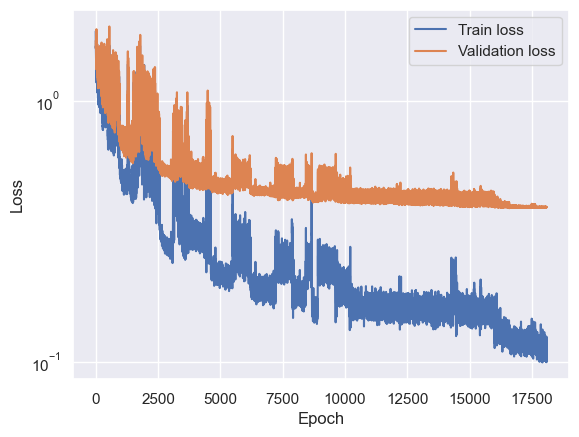

In [65]:
# Plot losses
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [66]:
# Test model    
test_loss = test_model(model, test_loader, loss_fn, device=device, normalize=normalized_TTF_data)
print("Test loss: ", test_loss)

Test loss:  1.060075283050537


In [27]:
# Show results
model.eval()
target = []
predicted = []
Vs_data = []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        target.append(y.cpu().numpy())
        predicted.append(y_pred.cpu().numpy())
        Vs_data.append(X.cpu().numpy())

target = np.concatenate(target)
predicted = np.concatenate(predicted)
Vs_data = np.concatenate(Vs_data)

# Undo log transformation
if normalized_TTF_data:
    target = denormalization(target)
    predicted = denormalization(predicted)

print(target.shape, predicted.shape, Vs_data.shape)

(15, 1000) (15, 1000) (15, 1, 30)


In [28]:
# Get the correlation factor between target and predicted
from scipy.stats import pearsonr

for i in range(target.shape[0]):
    print("Correlation factor for TTF ", i,"and Vs ", str(Vs_data[i,0,0]), " : ", pearsonr(target[i], predicted[i])[0])

Correlation factor for TTF  0 and Vs  552.104  :  0.9926933480834249
Correlation factor for TTF  1 and Vs  739.679  :  0.9951480671480841
Correlation factor for TTF  2 and Vs  489.579  :  0.993797335775342
Correlation factor for TTF  3 and Vs  148.096  :  0.9189621459799806
Correlation factor for TTF  4 and Vs  119.238  :  0.9069966788786559
Correlation factor for TTF  5 and Vs  475.15  :  0.9954468689231383
Correlation factor for TTF  6 and Vs  181.764  :  0.9212275555685636
Correlation factor for TTF  7 and Vs  258.717  :  0.9607956334960996
Correlation factor for TTF  8 and Vs  321.242  :  0.9498646917774338
Correlation factor for TTF  9 and Vs  744.489  :  0.9979485398731696
Correlation factor for TTF  10 and Vs  797.395  :  0.988527360740727
Correlation factor for TTF  11 and Vs  205.812  :  0.9102536931855312
Correlation factor for TTF  12 and Vs  758.918  :  0.9981476128495776
Correlation factor for TTF  13 and Vs  427.054  :  0.9892023648718624
Correlation factor for TTF  14 an

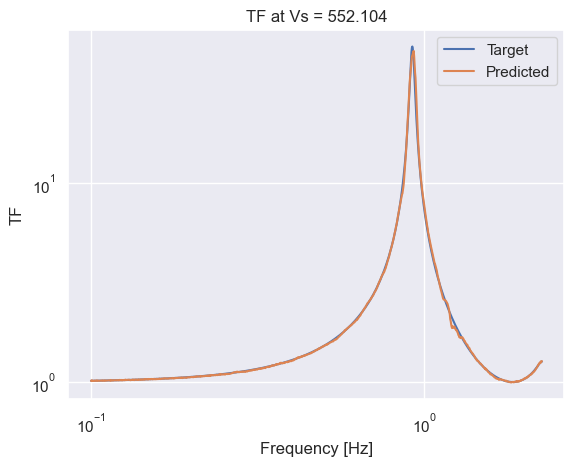

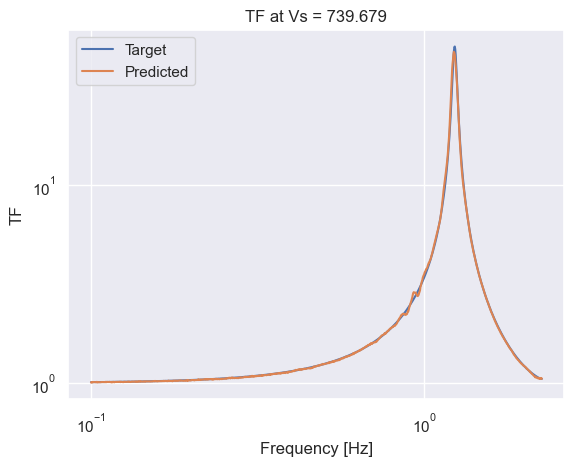

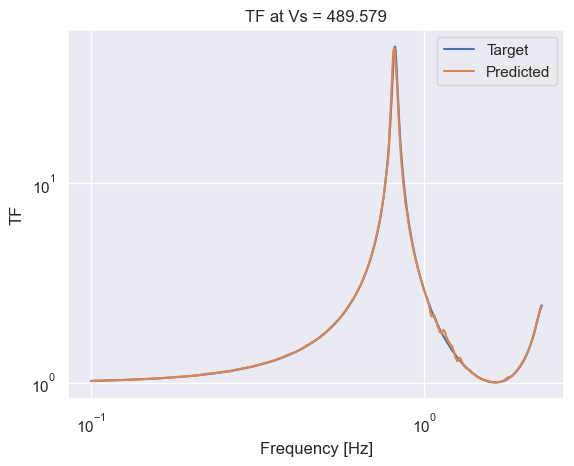

In [29]:
for i in range(target.shape[0]):
    plt.loglog(freq_data, target[i,:], label="Target")
    plt.loglog(freq_data, predicted[i,:], label="Predicted")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("TF")
    plt.title("TF at Vs = " + str(Vs_data[i,0,0]))
    plt.legend()
    plt.show()

    if i == 2:
        break

# Checking

In [67]:
# Create a lodaer for the whole dataset
all_loader = DataLoader(dataset, batch_size=1, shuffle=False)

correlations = []
Vs_range = []
predicted = []
target = []

with torch.no_grad():
    for X, y in all_loader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X, device)
        if normalized_TTF_data:
            y_pred = denormalization(y_pred)
            y = denormalization(y)
        correlations.append(pearsonr(y.cpu().numpy().flatten(), y_pred.cpu().numpy().flatten())[0])
        Vs_range.append(X.cpu().numpy().flatten()[0])
        predicted.append(y_pred.cpu().numpy().squeeze())
        target.append(y.cpu().numpy().squeeze())

correlations = np.array(correlations)
Vs_range = np.array(Vs_range)
predicted = np.array(predicted)
target = np.array(target)

print(correlations.shape, Vs_range.shape, predicted.shape, target.shape)



(146,) (146,) (146, 256) (146, 256)


In [68]:
# Save correlation results

#np.savetxt(os.path.join(path,"correlations_1000_log_norm.csv"), correlations, delimiter=",")
#np.savetxt(os.path.join(path,"Vs_pred_1000_log_norm.csv"), predicted, delimiter=",")

np.savetxt(os.path.join(path, "Vs_range.csv"), Vs_range, delimiter=",")
np.savetxt(os.path.join(path, "TTF_target_256.csv"), target, delimiter=",")

In [32]:
target.shape

(146, 1000)

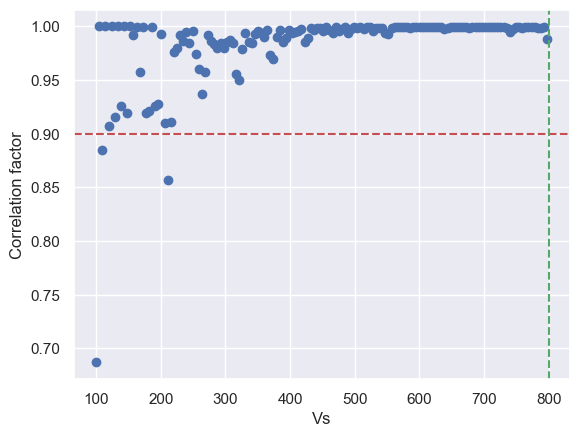

In [33]:
plt.scatter(Vs_range,correlations)
plt.xlabel("Vs")
plt.ylabel("Correlation factor")

# Add horizontal line at 0.9
plt.axhline(y=0.9, color='r', linestyle='--')

# Add vertical transparency after VS = 800
plt.axvline(x=800, color='g', linestyle='--')

#plt.yscale("log")
plt.show()

In [34]:
Vs_range[np.abs(Vs_range - 181.764).argmin()]

181.764

In [35]:
Vs_range.shape

(146,)

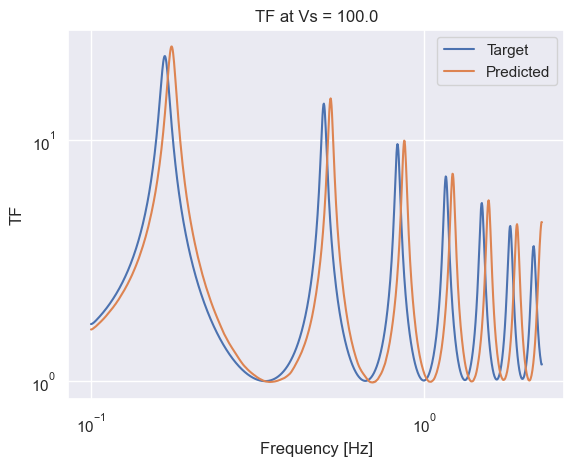

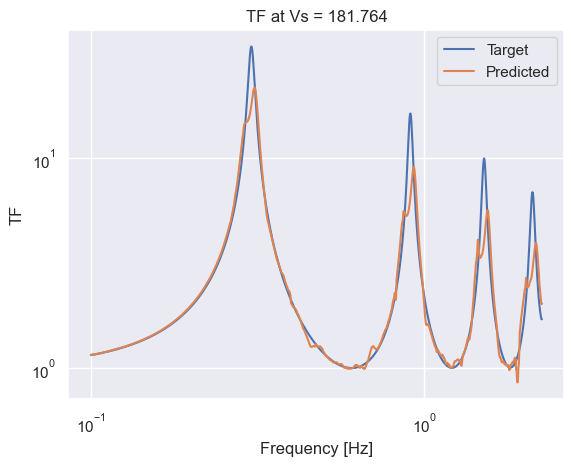

In [36]:
# Plot predicted
for i in range(predicted.shape[0]):

    if Vs_range[i] in [100, Vs_range[17]]:
        plt.loglog(freq_data, target[i,:], label="Target")
        plt.loglog(freq_data, predicted[i,:], label="Predicted")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("TF")
        plt.title("TF at Vs = " + str(Vs_range[i]))
        plt.legend()
        plt.show()

In [37]:
# Save model
#torch.save(model.state_dict(), os.path.join(r"FLAC\FLAC2D\1D 1 Column\model_save","model_CNN_RNN_1000_log_norm.pt"))

In [38]:
# 